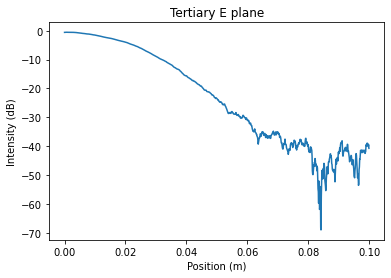

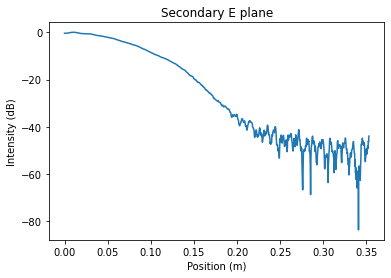

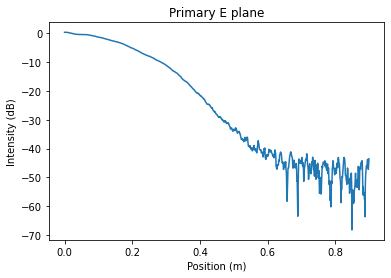

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

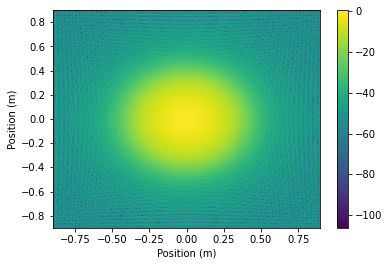

In [1]:
# From lens to primary... @ 100GHz
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy

# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.2 * u.cm
tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)

# separations 
d_lens_3 = 33.06 * u.cm
d_3_2 = 86.562 * u.cm
d_2_1 = 104.995 * u.cm
d_IF = 19.2 * u.cm

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
ff = 100 * u.GHz #ffs = [510 * u.GHz] # [480*u.GHz,540*u.GHz]
widths=[0.5*u.cm] #, 1*u.cm, 2*u.cm, 3*u.cm]


mirrors=['Tertiary','Secondary','Primary']
for it in np.arange(1,4):    
    plt.figure(it)  
    plt.title(mirrors[it-1]+" E plane")
    plt.xlabel("Position (m)")
    plt.ylabel("Intensity (dB)")
    
for width in widths: # not actually looping, but saving loop if I want it later
    ll = const.c/ff

    wf = poppy.FresnelWavefront(beam_radius=5*u.cm, wavelength=ll)

    tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
    secondary_obj = poppy.QuadraticLens(f_lens=f_2)
    primary_obj = poppy.QuadraticLens(f_lens=f_1)
    
    lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
    wf *= lenslet_aperture

    ring = poppy.CircularAperture(radius=0.05*u.m)
    wf *= ring # cold stop

    wf.propagate_fresnel(d_lens_3) # propogate to center of tertiary

    wf *= tertiary_obj
    
    y, x = wf.coordinates()
    plt.figure(1)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(width))
     
    wf.propagate_fresnel(d_3_2) # propogate from tertiary to secondary
    
    # for comparison with CST
    y2, x2 = wf.coordinates()
    pop_power = wf.intensity
    
    wf *= secondary_obj
    
    y, x = wf.coordinates()
    plt.figure(2)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(width))
    
    wf.propagate_fresnel(d_2_1) # propogate from secondary to primary
               
    y, x = wf.coordinates()
    plt.figure(3)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(width))

for it in np.arange(1,4):    
    plt.figure(it)
    plt.show()
    plt.clf()

a=0 # Toggles zoom
b=2048-a
fig, ax = plt.subplots()
c=ax.pcolormesh(x[a:b,a:b],y[a:b,a:b],10*np.log10(wf.intensity[a:b,a:b]))
fig.colorbar(c,ax=ax)
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()

c:\users\siebe\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
c:\users\siebe\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


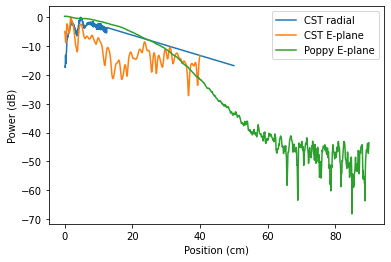

In [8]:
# these text files are not on the Github, but let me know if you want them...
rbeam=np.loadtxt('../EXCLAIM_Data/Primary1/rbeam.txt')
rbeampos=np.loadtxt('../EXCLAIM_Data/Primary1/rbeampos.txt')
xbeam=np.loadtxt('../EXCLAIM_Data/Primary1/xbeam.txt')
xbeampos=np.loadtxt('../EXCLAIM_Data/Primary1/xbeampos.txt')

plt.plot(rbeampos,10*np.log10(rbeam)-np.max(10*np.log10(rbeam)),label='CST radial')
plt.plot(xbeampos,10*np.log10(xbeam)-np.max(10*np.log10(xbeam)),label='CST E-plane')
plt.plot(100*x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label='Poppy E-plane')
plt.xlabel('Position (cm)')
plt.ylabel('Power (dB)')
plt.legend()
plt.show()

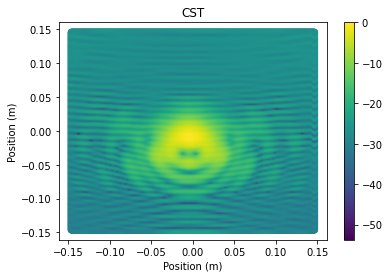

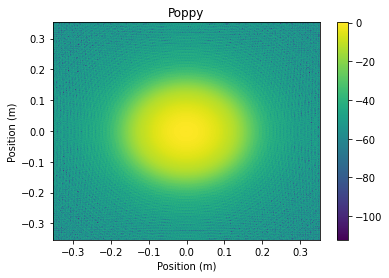

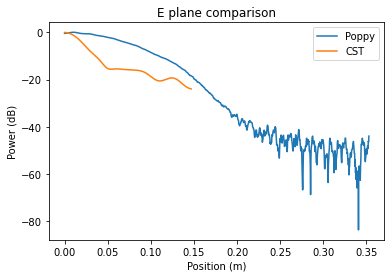

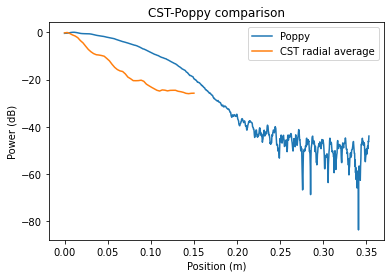

In [2]:
import math
xpos=np.loadtxt('../EXCLAIM_Data/US2run8/xpos.txt')
zpos=np.loadtxt('../EXCLAIM_Data/US2run8/zpos.txt')
power=np.loadtxt('../EXCLAIM_Data/US2run8/power.txt')

xpos=xpos/100 # convert from cm to m
zpos=zpos/100

fig, ax = plt.subplots()
scaling=10*np.log10(power)-max(10*np.log10(power))
c=ax.scatter(xpos,zpos,c=scaling)
fig.colorbar(c,ax=ax)
plt.title('CST')
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()

plt.pcolormesh(x2,y2,10*np.log10(pop_power))
#plt.scatter(x2,y2,10*np.log10(pop_power))
plt.colorbar()
plt.title('Poppy')
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()

Epos=np.zeros(len(xpos))
Epow=np.zeros(len(xpos))
count=0
zmin=min(abs(zpos))+0.001
for it in np.arange(0,len(xpos)):
    if abs(zpos[it])<=zmin:
        if xpos[it]>=0:
            Epow[count]=power[it]
            Epos[count]=xpos[it]
            count += 1
            #print(zpos[it])
            
Epos=Epos[:count]
Epow=10*np.log10(Epow[:count])
Epowmax=max(Epow)
        
plt.plot(x2[pop_power.shape[1]//2,1024:], 10*np.log10(pop_power[pop_power.shape[1]//2,1024:]),label='Poppy')
plt.plot(Epos,Epow-Epowmax,label='CST')
plt.title('100GHz E plane comparison')
plt.xlabel('Position (m)')
plt.ylabel('Power (dB)')
plt.legend()
plt.show()

radii=np.linspace(0,0.15)
radialpow=np.zeros_like(radii)
radialnorm=np.zeros_like(radii)
for it in np.arange(0,len(xpos)):
    #done=False
    #rit=1
    r=np.sqrt(xpos[it]**2+zpos[it]**2)
    idx=int(math.floor(r*50/0.15))
    if idx < 50:    
        radialpow[idx] += power[it]
        radialnorm[idx] += 1
    #while done==False:
    #    if r <radii[rit]:
    #        radialpow += power[it]
    #        radialnorm += 1
    #        done==True
    #    elif rit==49: #number of it s in linspace less one
    #        done==True
    #    else:
    #        rit +=1
    
            
for it in np.arange(0,len(radii)):
    radialpow[it]=radialpow[it]/radialnorm[it] # convert from total to mean power

maxrpow=max(10*np.log10(radialpow))    
radialpow=10*np.log10(radialpow)-maxrpow # convert to normalized dB

plt.plot(x2[pop_power.shape[1]//2,1024:], 10*np.log10(pop_power[pop_power.shape[1]//2,1024:]),label='Poppy')
plt.plot(radii,radialpow,label='CST radial average')
plt.title('100GHz CST-Poppy comparison')
plt.xlabel('Position (m)')
plt.ylabel('Power (dB)')
plt.legend()
plt.show()            
        
    

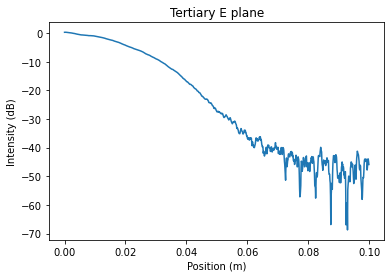

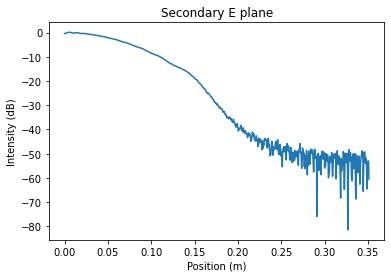

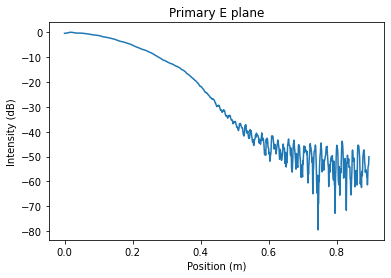

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

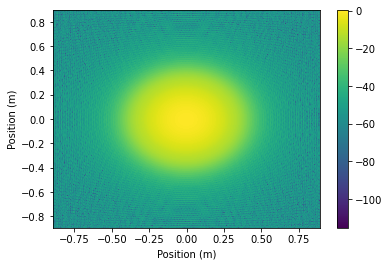

In [1]:
# From lens to primary... @ 200GHz
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy

# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.2 * u.cm
tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)

# separations 
d_lens_3 = 33.06 * u.cm
d_3_2 = 86.562 * u.cm
d_2_1 = 104.995 * u.cm
d_IF = 19.2 * u.cm

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
ff = 200 * u.GHz #ffs = [510 * u.GHz] # [480*u.GHz,540*u.GHz]
widths=[0.5*u.cm] #, 1*u.cm, 2*u.cm, 3*u.cm]


mirrors=['Tertiary','Secondary','Primary']
for it in np.arange(1,4):    
    plt.figure(it)  
    plt.title(mirrors[it-1]+" E plane at 200GHz")
    plt.xlabel("Position (m)")
    plt.ylabel("Intensity (dB)")
    
for width in widths: # not actually looping, but saving loop if I want it later
    ll = const.c/ff

    wf = poppy.FresnelWavefront(beam_radius=5*u.cm, wavelength=ll)

    tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
    secondary_obj = poppy.QuadraticLens(f_lens=f_2)
    primary_obj = poppy.QuadraticLens(f_lens=f_1)
    
    lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
    wf *= lenslet_aperture

    ring = poppy.CircularAperture(radius=0.05*u.m)
    wf *= ring # cold stop

    wf.propagate_fresnel(d_lens_3) # propogate to center of tertiary

    wf *= tertiary_obj
    
    y, x = wf.coordinates()
    plt.figure(1)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(width))
     
    wf.propagate_fresnel(d_3_2) # propogate from tertiary to secondary
    
    # for comparison with CST
    y2, x2 = wf.coordinates()
    pop_power = wf.intensity
    
    wf *= secondary_obj
    
    y, x = wf.coordinates()
    plt.figure(2)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(width))
    
    wf.propagate_fresnel(d_2_1) # propogate from secondary to primary
               
    y, x = wf.coordinates()
    plt.figure(3)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(width))

for it in np.arange(1,4):    
    plt.figure(it)
    plt.show()
    plt.clf()

a=0 # Toggles zoom
b=2048-a
fig, ax = plt.subplots()
c=ax.pcolormesh(x[a:b,a:b],y[a:b,a:b],10*np.log10(wf.intensity[a:b,a:b]))
fig.colorbar(c,ax=ax)
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()

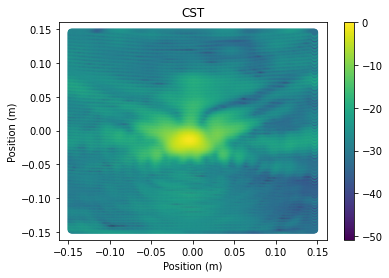

(92418,)
(92418,)


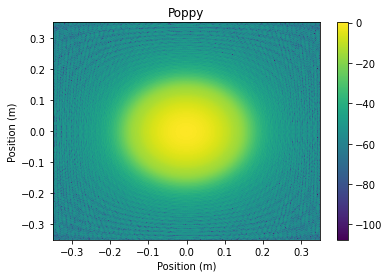

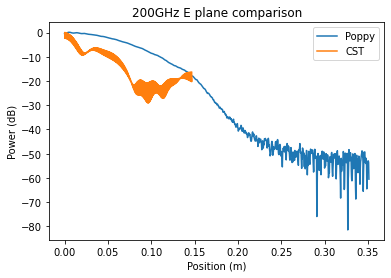

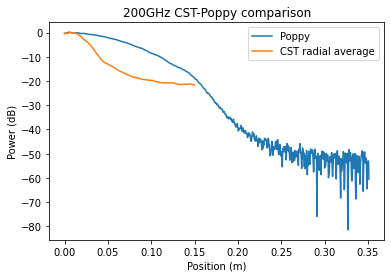

In [4]:
import math
xpos=np.loadtxt('../EXCLAIM_Data/USrun42minusrun43/xpos.txt')
zpos=np.loadtxt('../EXCLAIM_Data/USrun42minusrun43/zpos.txt')
power=np.loadtxt('../EXCLAIM_Data/USrun42minusrun43/power.txt')

xpos=xpos/100 # convert from cm to m
zpos=zpos/100

fig, ax = plt.subplots()
scaling=10*np.log10(power)-max(10*np.log10(power))
c=ax.scatter(xpos,zpos,c=scaling)
fig.colorbar(c,ax=ax)
plt.title('CST')
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()

plt.pcolormesh(x2,y2,10*np.log10(pop_power))
#plt.scatter(x2,y2,10*np.log10(pop_power))
plt.colorbar()
plt.title('Poppy')
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()

Epos=np.zeros(len(xpos))
Epow=np.zeros(len(xpos))
count=0
zmin=min(abs(zpos))+0.001
for it in np.arange(0,len(xpos)):
    if abs(zpos[it])<=zmin:
        if xpos[it]>=0:
            Epow[count]=power[it]
            Epos[count]=xpos[it]
            count += 1
            #print(zpos[it])
            
Epos=Epos[:count]
Epow=10*np.log10(Epow[:count])
Epowmax=max(Epow)
        
plt.plot(x2[pop_power.shape[1]//2,1024:], 10*np.log10(pop_power[pop_power.shape[1]//2,1024:]),label='Poppy')
plt.plot(Epos,Epow-Epowmax,label='CST')
plt.title('200GHz E plane comparison')
plt.xlabel('Position (m)')
plt.ylabel('Power (dB)')
plt.legend()
plt.show()

radii=np.linspace(0,0.15)
radialpow=np.zeros_like(radii)
radialnorm=np.zeros_like(radii)
for it in np.arange(0,len(xpos)):
    #done=False
    #rit=1
    r=np.sqrt(xpos[it]**2+zpos[it]**2)
    idx=int(math.floor(r*50/0.15))
    if idx < 50:    
        radialpow[idx] += power[it]
        radialnorm[idx] += 1
    #while done==False:
    #    if r <radii[rit]:
    #        radialpow += power[it]
    #        radialnorm += 1
    #        done==True
    #    elif rit==49: #number of it s in linspace less one
    #        done==True
    #    else:
    #        rit +=1
    
            
for it in np.arange(0,len(radii)):
    radialpow[it]=radialpow[it]/radialnorm[it] # convert from total to mean power

maxrpow=max(10*np.log10(radialpow))    
radialpow=10*np.log10(radialpow)-maxrpow # convert to normalized dB

plt.plot(x2[pop_power.shape[1]//2,1024:], 10*np.log10(pop_power[pop_power.shape[1]//2,1024:]),label='Poppy')
plt.plot(radii,radialpow,label='CST radial average')
plt.title('200GHz CST-Poppy comparison')
plt.xlabel('Position (m)')
plt.ylabel('Power (dB)')
plt.legend()
plt.show() 

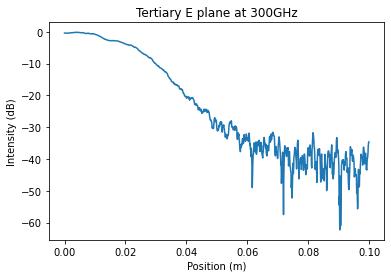

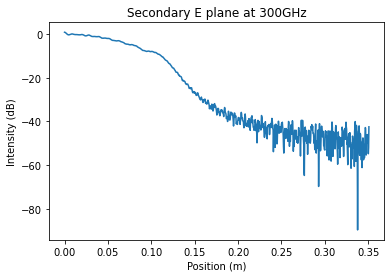

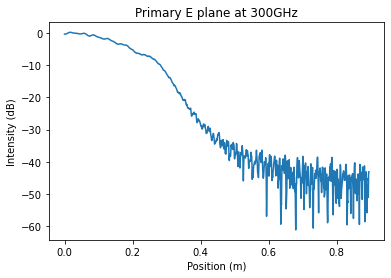

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

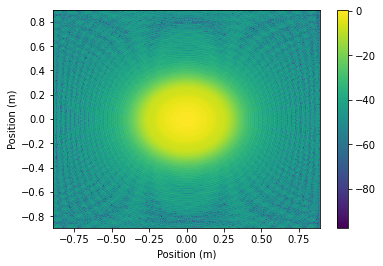

In [1]:
# From lens to primary... @ 300GHz
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy

# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.2 * u.cm
tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)

# separations 
d_lens_3 = 33.06 * u.cm
d_3_2 = 86.562 * u.cm
d_2_1 = 104.995 * u.cm
d_IF = 19.2 * u.cm

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
ff = 300 * u.GHz #ffs = [510 * u.GHz] # [480*u.GHz,540*u.GHz]
widths=[0.5*u.cm] #, 1*u.cm, 2*u.cm, 3*u.cm]


mirrors=['Tertiary','Secondary','Primary']
for it in np.arange(1,4):    
    plt.figure(it)  
    plt.title(mirrors[it-1]+" E plane at 300GHz")
    plt.xlabel("Position (m)")
    plt.ylabel("Intensity (dB)")
    
for width in widths: # not actually looping, but saving loop if I want it later
    ll = const.c/ff

    wf = poppy.FresnelWavefront(beam_radius=5*u.cm, wavelength=ll)

    tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
    secondary_obj = poppy.QuadraticLens(f_lens=f_2)
    primary_obj = poppy.QuadraticLens(f_lens=f_1)
    
    lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
    wf *= lenslet_aperture

    ring = poppy.CircularAperture(radius=0.0381*u.m)
    wf *= ring # cold stop

    wf.propagate_fresnel(d_lens_3) # propogate to center of tertiary

    wf *= tertiary_obj
    
    y, x = wf.coordinates()
    plt.figure(1)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(width))
     
    wf.propagate_fresnel(d_3_2) # propogate from tertiary to secondary
    
    # for comparison with CST
    y2, x2 = wf.coordinates()
    pop_power = wf.intensity
    
    wf *= secondary_obj
    
    y, x = wf.coordinates()
    plt.figure(2)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(width))
    
    wf.propagate_fresnel(d_2_1) # propogate from secondary to primary
               
    y, x = wf.coordinates()
    plt.figure(3)
    plt.plot(x[wf.intensity.shape[1]//2,1024:], 10*np.log10(wf.intensity[wf.intensity.shape[1]//2,1024:]),label=str(width))

for it in np.arange(1,4):    
    plt.figure(it)
    plt.show()
    plt.clf()

a=0 # Toggles zoom
b=2048-a
fig, ax = plt.subplots()
c=ax.pcolormesh(x[a:b,a:b],y[a:b,a:b],10*np.log10(wf.intensity[a:b,a:b]))
fig.colorbar(c,ax=ax)
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()

(164171,)
(164171,)
(164171,)


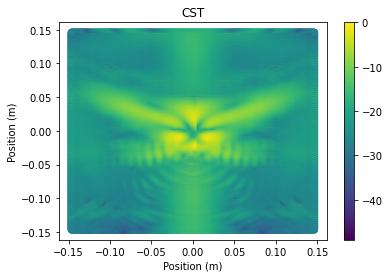

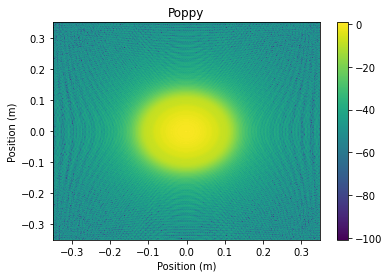

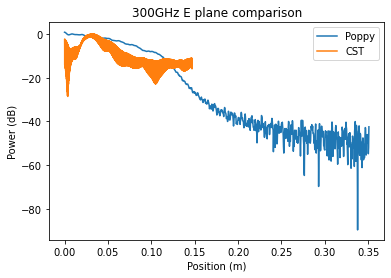

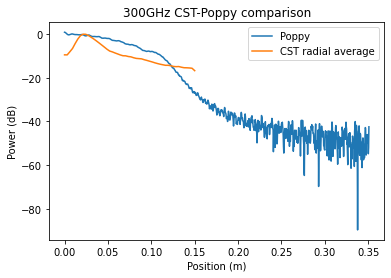

In [8]:
import math
xpos=np.loadtxt('../EXCLAIM_Data/US2run8.2/xpos.txt')
zpos=np.loadtxt('../EXCLAIM_Data/US2run8.2/zpos.txt')
power=np.loadtxt('../EXCLAIM_Data/US2run8.2/power.txt')

xpos=xpos/100 # convert from cm to m
zpos=zpos/100

fig, ax = plt.subplots()
scaling=10*np.log10(power)-max(10*np.log10(power))
scaling=np.concatenate((scaling, scaling), axis=0) #This will serve to mirror the CST field monitor over the plane of symmetry
xp=np.concatenate((xpos, -xpos), axis=0)
zp=np.concatenate((zpos, zpos), axis=0)
c=ax.scatter(xp,zp,c=scaling)
fig.colorbar(c,ax=ax)
plt.title('CST')
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()


plt.pcolormesh(x2,y2,10*np.log10(pop_power))
#plt.scatter(x2,y2,10*np.log10(pop_power))
plt.colorbar()
plt.title('Poppy')
plt.xlabel('Position (m)')
plt.ylabel('Position (m)')
plt.show()

Epos=np.zeros(len(xpos))
Epow=np.zeros(len(xpos))
count=0
zmin=min(abs(zpos))+0.001
for it in np.arange(0,len(xpos)):
    if abs(zpos[it])<=zmin:
        if xpos[it]>=0:
            Epow[count]=power[it]
            Epos[count]=xpos[it]
            count += 1
            #print(zpos[it])
            
Epos=Epos[:count]
Epow=10*np.log10(Epow[:count])
Epowmax=max(Epow)
        
plt.plot(x2[pop_power.shape[1]//2,1024:], 10*np.log10(pop_power[pop_power.shape[1]//2,1024:]),label='Poppy')
plt.plot(Epos,Epow-Epowmax,label='CST')
plt.title('300GHz E plane comparison')
plt.xlabel('Position (m)')
plt.ylabel('Power (dB)')
plt.legend()
plt.show()

radii=np.linspace(0,0.15)
radialpow=np.zeros_like(radii)
radialnorm=np.zeros_like(radii)
for it in np.arange(0,len(xpos)):
    #done=False
    #rit=1
    r=np.sqrt(xpos[it]**2+zpos[it]**2)
    idx=int(math.floor(r*50/0.15))
    if idx < 50:    
        radialpow[idx] += power[it]
        radialnorm[idx] += 1
    #while done==False:
    #    if r <radii[rit]:
    #        radialpow += power[it]
    #        radialnorm += 1
    #        done==True
    #    elif rit==49: #number of it s in linspace less one
    #        done==True
    #    else:
    #        rit +=1
    
            
for it in np.arange(0,len(radii)):
    radialpow[it]=radialpow[it]/radialnorm[it] # convert from total to mean power

maxrpow=max(10*np.log10(radialpow))    
radialpow=10*np.log10(radialpow)-maxrpow # convert to normalized dB

plt.plot(x2[pop_power.shape[1]//2,1024:], 10*np.log10(pop_power[pop_power.shape[1]//2,1024:]),label='Poppy')
plt.plot(radii,radialpow,label='CST radial average')
plt.title('300GHz CST-Poppy comparison')
plt.xlabel('Position (m)')
plt.ylabel('Power (dB)')
plt.legend()
plt.show() 